In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

# Load evaluation results

In [3]:
DATASET_NAMES = ["census", "wine", "credit"]
EVAL_MODELS = dict([(dn, pd.read_csv("../out/eval/{}.csv".format(dn), sep=",")) for dn in DATASET_NAMES])
EVAL_METRICS = ["Accuracy", "F1 Macro", "ROC AUC"]

DATASET_CLEAN_NAMES = {"census": "census", "wine":"wine", "credit": "credit"}

STD_MODELS = ["GBDT", "Random Forest"]
ROBUST_MODELS = ["Adv Boosting", "Robust Trees", "RF-Treant"]

# Add <code>Accuracy</code> column

In [4]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Accuracy'] = 1 - eval_df['Binary Err Rate']
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:3] + [colnames[-1]] + colnames[3:-1]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# Normalize <code>Budget</code> values

In [5]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Test Budget Norm'] = round(eval_df['Test Budget']/eval_df['Test Budget'].max(), 2)
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:2] + [colnames[-1]] + colnames[2:-1]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# 1. Plot Standard GBDT vs. RF

In [6]:
def plot_std(data, ax, metric):
    
    palette = ["#f37736", "#3385c6"] 
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     style_order=["Random Forest", "GBDT"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Test Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)

In [7]:
def plot_std_dataset(df, metrics, std_models, axes):
    
    for m_i, m in enumerate(metrics):   
        plot_std(df[(df['Model']=='GBDT') | (df['Model']=='Random Forest')], axes[m_i], m)
    
    plt.tight_layout(pad=1)
        

In [8]:
def plot_all_std_datasets(eval_models, eval_metrics, std_models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 8))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_std_dataset(eval_models[dataset], eval_metrics, std_models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname='Courier New')
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    for ax in flat_axes:
        ax.get_legend().remove()  
    
    fig.legend(handles=handles[::-1], 
               labels=labels[::-1],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.07), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=2,
               markerscale=2.
              )
        
    

Generating evaluation subplot for dataset `census`...
Generating evaluation subplot for dataset `wine`...
Generating evaluation subplot for dataset `credit`...


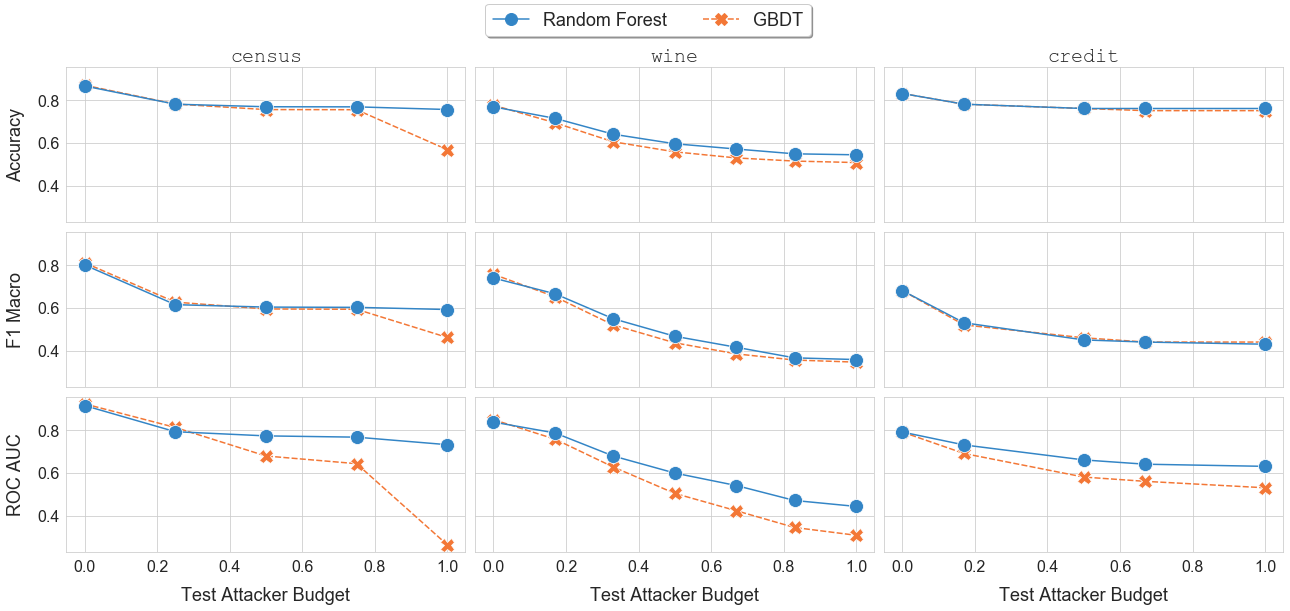

In [9]:
plot_all_std_datasets(EVAL_MODELS, EVAL_METRICS, STD_MODELS, DATASET_CLEAN_NAMES)

# 2. Plot Adversarial Boosting vs. Robust Trees vs. RF-Treant

In [10]:
def plot_atk(data, ax, metric):
    
    palette = ["#ee2e31", "#ffc425", "#009688"] #ee4035 "#4281a4" "#edc951"
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     style_order=["RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Training/Test Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)

In [23]:
def plot_atk_dataset(df, metrics, models, axes):
    
    test_budgets = df["Test Budget"].unique()[1:]
    
    data = []
    
    for m_i, m in enumerate(metrics):
        for b_i, b in enumerate(test_budgets):
            # mask = []
            # for rm in robust_models:
                # mask.append("{} [train budget={}]".format(rm, b))
            # data.append(df.loc[(df["Model"].isin(mask)) & (df["Budget"] == b)].replace(regex=r' \[train.*\]', value=''))
            data.append(df.loc[(df["Model"].isin(models)) & (df["Training Budget"] == b)]) # & (df["Test Budget"] == b)])
            
        plot_atk(pd.concat(data, axis=0), axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [24]:
def plot_all_atk_datasets(eval_models, eval_metrics, robust_models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 10))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_atk_dataset(eval_models[dataset], eval_metrics, robust_models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    for ax in flat_axes:
        ax.get_legend().remove()  
    
    fig.legend(handles=[handles[2], handles[0], handles[1]], 
               labels=[labels[2], labels[0], labels[1]],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=3,
               markerscale=2.
              )
        
    

Generating evaluation subplot for dataset `census`...
Generating evaluation subplot for dataset `wine`...
Generating evaluation subplot for dataset `credit`...


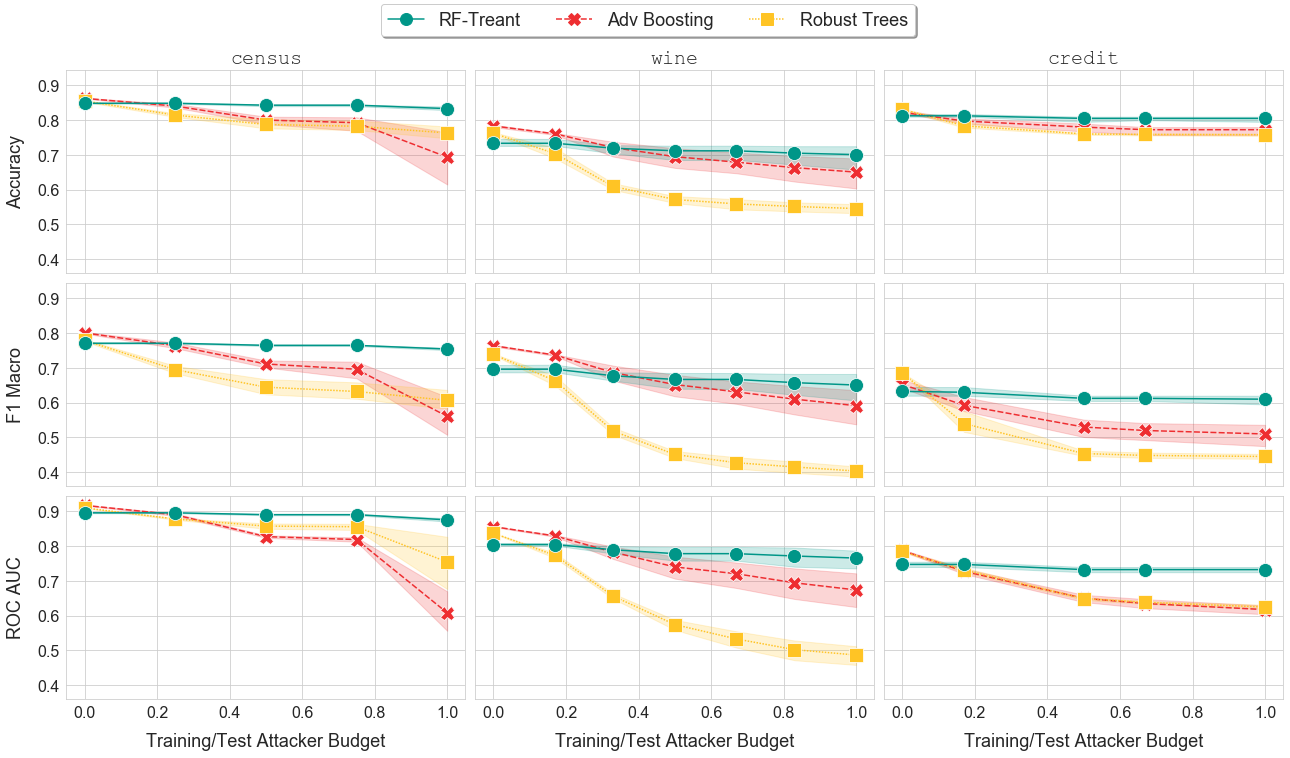

In [25]:
plot_all_atk_datasets(EVAL_MODELS, EVAL_METRICS, ROBUST_MODELS, DATASET_CLEAN_NAMES)

# 3. Efficiency-Robustness Tradeoff

In [ ]:
def plot_tradeoff(data, ax, metric):
    
    #palette = ["#f37736", "#3385c6"] 
    
    _ = sns.lineplot(x="Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     #style_order=["Random Forest", "GBDT"],
                     data=data,
                     markersize=14,
                     #palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Train Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)

In [ ]:
def plot_tradeoff_dataset(df, metrics, axes):
    
    for m_i, m in enumerate(metrics):   
        plot_tradeoff(df[df['Budget']==0], axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [ ]:
def plot_all_tradeoff_datasets(eval_models, eval_metrics):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 10))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_tradeoff_dataset(eval_models[dataset], eval_metrics, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")

In [ ]:
plot_all_tradeoff_datasets(EVAL_MODELS, EVAL_METRICS)

# OLD VERSION!!! Plot GBDT vs. RF under attack

In [ ]:
# #d11141 #00b159 #00aedb #f37735 #ffc425

def plot_standard(eval_df, dataset_name, eval_metrics, ax):
    sns.set_style("whitegrid")
    atk_budgets = eval_df['Budget Norm'].unique()
    #fig, ax = plt.subplots(1, 1, figsize=(6,6))
    palette = ['#d11141', '#00b159'] #, '#00aedb', '#f37735', '#ffc425', '#8874a3']
    palette = ['#00aedb', '#d11141']
    ls = ['-', '--']
    markers=['^', 's','o']
    for i, metric in enumerate(eval_metrics):
        _ = sns.lineplot(x="Budget Norm", 
                        y= metric, 
                        hue="Model",
                        markers=[markers[i], markers[i]],
                        style="Model",
                        style_order=["GBDT", "Random Forest"],
                        palette=palette, #[i*2:i*2+2],
                        data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')],
                        markersize=12,
                        ax=ax)
        #_ = ax.set_xlabel("attacker's budget", fontsize=18, labelpad=12)
        #_ = ax.set_ylabel("metric", fontsize=18, labelpad=12)
        _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
        _ = ax.set_title(dataset_name, fontsize=22)
        legend_elements = [Line2D([0], [0], color='#00aedb', lw=2),
                           Line2D([0], [0], color='#d11141', lw=2, ls="--"),
                           Line2D([0], [0], color='black', lw=1, marker="^", markersize=8), #, mew=3),
                           Line2D([0], [0], color='black', lw=1, marker="s", markersize=8),
                           Line2D([0], [0], color='black', lw=1, marker="o", markersize=8)
                          ]
        
        leg = ax.legend(title='Models', 
                      loc='best', 
                      handles=legend_elements, 
                      labels=['GBDT', 'Random Forest', 'Accuracy', 'F1 Macro', 'ROC AUC'],
                      borderpad=1,
                      fontsize=16)
        leg.get_title().set_fontsize(16)

In [ ]:
def plot_all_standard(eval_dict, eval_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,8))
    i = 0
    for dataset_name in eval_dict:
        print("Plotting GBDT vs. RF under attack for dataset `{}`...".format(dataset_name))
        plot_standard(eval_dict[dataset_name], dataset_name, eval_metrics, axes[i])
        axes[i].set_xlabel("attacker's budget", fontsize=20, labelpad=12)          
        if i == 0:
            axes[i].set_ylabel("metric", fontsize=20, labelpad=12)
        i += 1
    plt.tight_layout(pad=2.5)
    

In [ ]:
plot_all_standard(EVAL_MODELS, EVAL_METRICS)